# COSMIC ZOO: A MICROBIOME ANALYSIS OF EXTRAPLANATARY CREATURES
---

## Set Up Notebook

- [Imports](#Imports), 
- [Helpers](#Helpers)
- [Constants](#Constants)


## Data Preprocessing

## Questions

### Warm Up Problems
- [Identifying Animal Volunteers](#Identifying-Volunteers)
- [Identifying Animal Locations](#Identifying-Animal-Locations)


### Microbiome Predictions 

#### Setup
- Load microbiome data into dataframe

#### Solutions
- [Predict Planet of Origin](#Predict-Planet-of-Origin-from-Microbiome)
- [Predict Sex](#Predict-Lifestage-of-Animal-from-Microbiome)
- [Predict Lifestage](#Predict-Lifestage-of-Animal-from-Microbiome)


### Biome Correlation
- [Identify Correlated Organisms]
- [Identify Correlation Between Daily Activity and Microbes]
- [Look at Diet Microbe Correlation]

### Other Research

## Imports 

In [761]:
# ----------------- #
# General           #
# ----------------- #
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
from sqlalchemy import create_engine
import re


# ----------------- #
# Visualization     #
# ----------------- #
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
%matplotlib inline

 
# ----------------- #
# Machine Learning  #
# ----------------- #

# custome transformer
from sklearn.base import BaseEstimator, TransformerMixin

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# preprocsesing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# models
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

# model evalution
from sklearn.metrics import confusion_matrix, f1_score, classification_report

## Helpers 

In [655]:
def logger(f, *args, **kwargs):
    def wrapper(*args, **kwargs):
        start = datetime.now()
        result = f(*args, **kwargs)
        end = datetime.now() 
        print(f'{f.__name__} took {end-start} time')
        return result
    return wrapper

class DropColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_indices):
        self.column_indices = column_indices
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        cleaned_column_indices = [ci if ci>=0 else X.shape[1]-(ci+2) for ci in self.column_indices] 
        return np.delete(X, cleaned_column_indices, axis=1)

## Constants

In [735]:
US_STATES = gpd.read_file('https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_20m.json')
US_X_BOUNDS = [-180, -60]

In [250]:
con = create_engine('postgres://samuelmignot@localhost/cosmic_zoo')

## Load Data into SQL DB

In [253]:
con = create_engine('postgres://samuelmignot@localhost/cosmic_zoo')

# load and melt feature
features = pd.read_csv('./feature-table.tsv', delimiter='\t', header=1)
features = features.drop(columns=['Blank']).melt(id_vars='Feature_ID', var_name='Sample_ID', value_name='value')

# load taxonomy
taxonomy = pd.read_csv('./taxonomy.tsv', delimiter='\t')

# load metadata
xls = pd.ExcelFile('metadata.xls')
metadata = [pd.read_excel(xls, sheeet) for sheeet in xls.sheet_names]

# clean table names for sql DB
table_names = [
    'feature', 
    'taxonomy', 
    *[sn.replace('_info', "").replace('_results', "").strip() for sn in xls.sheet_names]
]

tables = [features, taxonomy, *metadata]
    
def clean_columns(df):
    return (df
     .rename(columns={'dog_id': 'animal_id'})
     .rename(columns=str.lower)
     .rename(columns=lambda s: re.sub(r'\([^)]*\)', '', s))
     .rename(columns=str.strip)
     .rename(columns=lambda s: s.replace(' ', '-')))

@logger
def convert_data_to_sql(table_names, tables, con=con):
    for t_name, table in zip(table_names, tables):
        (table
         .dropna(axis=1,how='all')
         .pipe(clean_columns)
         .to_sql(t_name, con=con, index=False))

In [254]:
convert_data_to_sql(table_names, tables)

convert_data_to_sql took 0:00:13.152421 time


## Identifying Volunteers

In [261]:
volunteers = pd.read_sql("""
    SELECT 
      volunteer_name, 
      animal_name, 
      animal_id 
    FROM volunteer 
    JOIN animal ON volunteer.volunteer_id = animal.user_id""", con=con)
volunteers

,volunteer_name,animal_name,animal_id
0,James,Andy,P0001
1,Mary,Joy,P0003
2,Robert,Rei,P0004
3,Michael,Paco,P0005
4,Barbara,Teva,P0006
5,David,Chilly,P0011
6,Richard,Kaya,P0012
7,Charles,Mussi,P0320
8,Charles,Giveret,P0013
9,Joseph,Eva,P0014


## Identifying Animal Locations 

In [737]:
animal_locations = pd.read_sql("""
SELECT 
    animal_id, animal_name, state 
FROM volunteer 
JOIN animal ON volunteer.volunteer_id = animal.user_id 
""", con=con)

animal_locations

,animal_id,animal_name,state
0,P0001,Andy,Hawaii
1,P0003,Joy,Arkansas
2,P0004,Rei,Iowa
3,P0005,Paco,Florida
4,P0006,Teva,New Jersey
5,P0011,Chilly,Indiana
6,P0012,Kaya,California
7,P0320,Mussi,Indiana
8,P0013,Giveret,Indiana
9,P0014,Eva,Arkansas


(-180.0, -60.0)

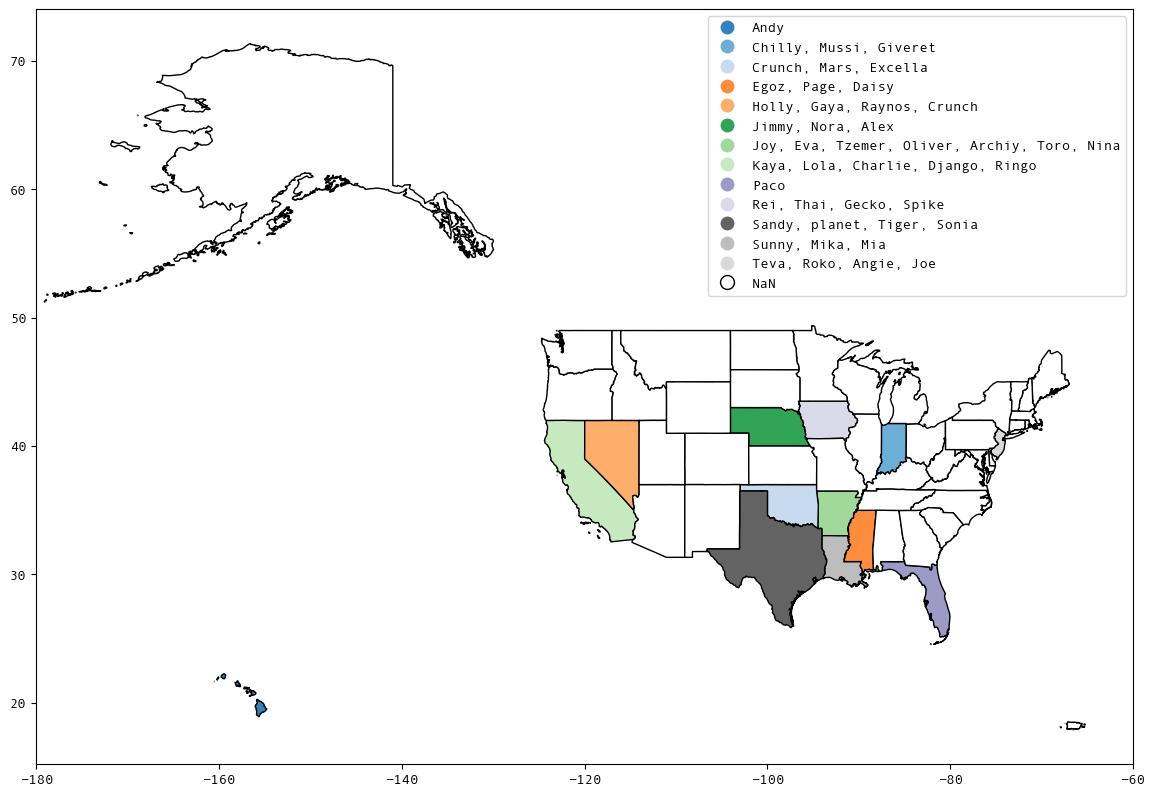

In [736]:
animal_states = US_STATES.join(animal_locations.set_index('state'), on='NAME')
animal_states.loc[animal_states.animal_name.isna(), 'animal_name'] = ""
plot_animal_states = gpd.GeoDataFrame(animal_states
                      .groupby(['NAME'], as_index=False)
                      .agg({'animal_name': lambda x: ', '.join(x)})
                      .merge(US_STATES, how='inner', on='NAME'))

plot_animal_states.loc[(plot_animal_states.animal_name==''), 'animal_name']=np.NaN

ax = plot_animal_states.plot(column='animal_name', missing_kwds = dict(color = "white",), cmap='tab20c', figsize=(15,10), legend=True, edgecolor='black')

ax.set_xlim(US_X_BOUNDS) # centers the plot on the united states by removing minor outlying islands from frame

## Load microbiome data into dataframe

In [731]:
animal_microbiome = pd.read_sql("""
SELECT 
    animal.animal_id, animal_name, planet_of_origin, sex, life_stage, age, microbiome_sample.*, feature.*
FROM animal  
JOIN microbiome_sample ON animal.animal_id= microbiome_sample.animal_id
JOIN feature ON microbiome_sample.sample_id=feature.sample_id;
""", con=con)

def clean_animal_microbiome(df):
    df_copy = df.copy()
    
    # remove duplicate columns
    df_copy = df_copy.loc[:,~df_copy.columns.duplicated()]
    
    # pivot table so that each sample is a row and all features are in columns 
    df_copy = df_copy.pivot(index=['animal_id', 'sample_id', 'planet_of_origin', 'sex', 'life_stage', 'age'], columns=['feature_id'], values=['value']).reset_index()
    
    # flatten multiindex columns
    df_copy.columns = [''.join(col) if col[0]!='value' else f'feature-{col[1]}' for col in df_copy.columns]
    return df_copy
    
cleaned_animal_microbiome = clean_animal_microbiome(animal_microbiome)
feature_columns = [c  for c in cleaned_animal_microbiome.columns if c.startswith('feature-')]

In [732]:
cleaned_animal_microbiome.head()

,animal_id,sample_id,planet_of_origin,sex,life_stage,age,feature-000048f702075932f8490742242f53bc,feature-0015c502708f2b691000338421d45481,feature-0030768b412e89179a3e95e8314246e0,feature-006340e125d729bc012b31674f8eeaab,...,feature-fd17074acfc5a30fc5f4b232526da760,feature-fd2c75f35b6d3fe0063279bf346b5bf1,feature-fd57a368f0d58e4a589a17acdeb79026,feature-fdc0703fd7ed12b743799a4e5d14609a,feature-fe0739bac994e3e75362a67c46a7d52c,feature-fe37b8d76901ab8f244cc6091b28f043,feature-fe951e497a18f389d934b58d62d0209a,feature-feb56be9c36fafc5a551fb366c69f139,feature-ff0af3e8ac32431bb0476639b81c7079,feature-ffd8a12af6963db11835da7e472f401c
0,OK001,1-OK001-A,Venus,female,Adult,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,OK001,2-OK001-B,Venus,female,Adult,3,0,0,0,0,...,0,30,0,0,0,0,0,0,0,0
2,OK001,3-OK001-C,Venus,female,Adult,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OK002,4-OK002-A,Venus,male,Senior,6,0,0,0,0,...,0,0,25,0,438,22,0,0,0,0
4,OK002,5-OK002-B,Venus,male,Senior,6,0,0,0,0,...,0,0,31,0,37,83,0,0,0,0


## Predict Planet of Origin from Microbiome

A few considerations for this problem: 
- test size is made slightly larger than standard because sample size is relatively small.
- Samples are considered not individual animal. Some animals havee duplicate entries because they were sampled multiple times. Duplicates were included to try to filter out the noise of diet

In [738]:
Planet_X_train, Planet_X_test, Planet_y_train, Planet_y_test = train_test_split(
    cleaned_animal_microbiome[feature_columns], 
    cleaned_animal_microbiome.planet_of_origin, 
    test_size=.3, 
    stratify=cleaned_animal_microbiome.planet_of_origin)

### Use Dimensionality Reduction Techniques to Analyze Potential Clusters and Linear Seperability

Ran microbiome data through a few dimensionality reduction algorithms to search for obvious clustering/linear seperability.

Due to the high dimensionality of the data, the results are not fruitful and analysis will not be repeated for other problems.

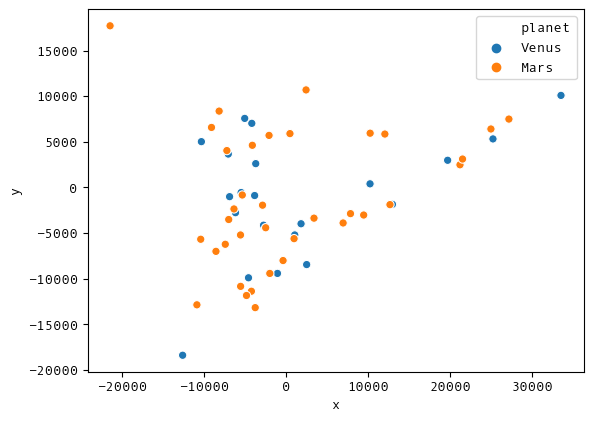

In [741]:
pca = PCA(n_components=2)
res = pca.fit_transform(Planet_X_train)

plot_pca = pd.DataFrame(res, columns=['x', 'y'])
plot_pca['planet'] = Planet_y_train
ax = sns.scatterplot(data=plot_pca, x='x', y='y', hue='planet', legend='full')


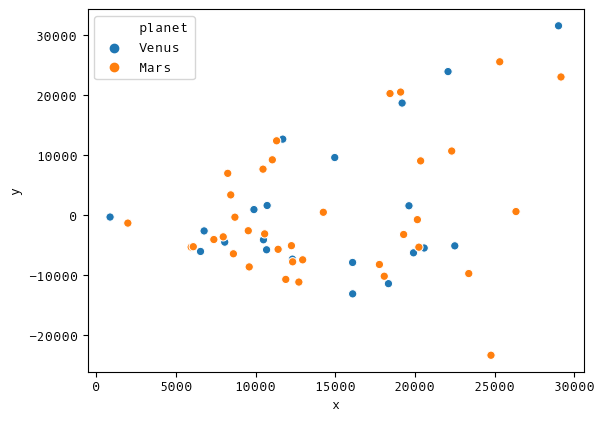

In [760]:
tsvd = TruncatedSVD()
res = tsvd.fit_transform(Planet_X_train)

plot_tsvd = pd.DataFrame(res, columns=['x', 'y'])
plot_tsvd['planet'] = Planet_y_train
ax = sns.scatterplot(data=plot_tsvd, x='x', y='y', hue='planet', legend='full')

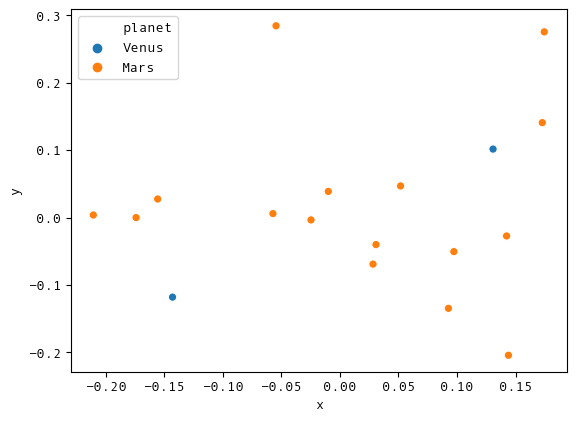

In [769]:
lle = LocallyLinearEmbedding(n_neighbors=1)
res = lle.fit_transform(Planet_X_train)

planet_plot_lle = pd.DataFrame(res, columns=['x', 'y'])
planet_plot_lle['planet'] = Planet_y_train
ax = sns.scatterplot(data=planet_plot_lle, x='x', y='y', hue='planet', legend='full')

### Train Linear Classifier 

In [812]:
## SGD Being Used Because Dataset is wide: LinearClassifier would be quite slow

params = {
    'penalty': ['l1', 'l2']
}


sgd_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('grid', GridSearchCV(SGDClassifier(), param_grid=params, cv=3)),
])

sgd_pipe.fit(Sex_X_train[feature_columns], Sex_y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('grid',
                 GridSearchCV(cv=3, estimator=SGDClassifier(),
                              param_grid={'penalty': ['l1', 'l2']}))])

In [813]:
res = sgd_pipe.predict(Sex_X_train[feature_columns])

In [814]:
print('SGD Classfier: Using Microbiome to Predict Plane of Origin\n')
print(classification_report(Sex_y_train, res))

SGD Classfier: Using Microbiome to Predict Plane of Origin

              precision    recall  f1-score   support

      female       1.00      1.00      1.00        45
        male       1.00      1.00      1.00        41

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



### Train Linear Classifier 

In [808]:
## SGD Being Used Because Dataset is wide: LinearClassifier would be quite slow

params = {
    'penalty': ['l1', 'l2']
}


sgd_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('grid', GridSearchCV(SGDClassifier(), param_grid=params, cv=3)),
])

sgd_pipe.fit(Planet_X_train, Planet_y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('grid',
                 GridSearchCV(cv=3, estimator=SGDClassifier(),
                              param_grid={'penalty': ['l1', 'l2']}))])

In [809]:
res = sgd_pipe.predict(Planet_X_train)

In [810]:
print('SGD Classfier: Using Microbiome to Predict Planet of Origin\n')
print(classification_report(Planet_y_train, res))

SGD Classfier: Using Microbiome to Predict Planet of Origin

              precision    recall  f1-score   support

        Mars       1.00      1.00      1.00        65
       Venus       1.00      1.00      1.00        21

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



## Predict Sex of Animals using Microbiome

A few considerations for this problem: 
- test size is made slightly larger than standard because sample size is relatively small.
- Samples are considered not individual animal. Some animals havee duplicate entries because they were sampled multiple times. Duplicates were included to try to filter out the noise of diet

In [794]:
Sex_X_train, Sex_X_test, Sex_y_train, Sex_y_test = train_test_split(
    cleaned_animal_microbiome[feature_columns], 
    cleaned_animal_microbiome.sex, 
    test_size=.3, 
    stratify=cleaned_animal_microbiome.sex)

In [795]:
Sex_X_train.head()

,feature-000048f702075932f8490742242f53bc,feature-0015c502708f2b691000338421d45481,feature-0030768b412e89179a3e95e8314246e0,feature-006340e125d729bc012b31674f8eeaab,feature-0084d67b7c9244ff78f308d8353edc9e,feature-008d968ec90dcc6308fef4db2234c8ae,feature-00b112199d6818d465d04411f799c543,feature-00b9c002ea861f3722335a25d0f74608,feature-00c61f059eb6f8b869b01e6754fd0cd0,feature-00e2387b5dbdd3d3c5b3d3cdaae229e9,...,feature-fd17074acfc5a30fc5f4b232526da760,feature-fd2c75f35b6d3fe0063279bf346b5bf1,feature-fd57a368f0d58e4a589a17acdeb79026,feature-fdc0703fd7ed12b743799a4e5d14609a,feature-fe0739bac994e3e75362a67c46a7d52c,feature-fe37b8d76901ab8f244cc6091b28f043,feature-fe951e497a18f389d934b58d62d0209a,feature-feb56be9c36fafc5a551fb366c69f139,feature-ff0af3e8ac32431bb0476639b81c7079,feature-ffd8a12af6963db11835da7e472f401c
72,0,0,0,0,0,0,0,0,0,0,...,0,165,0,0,639,0,0,0,0,0
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,335,0,0,0,0
47,0,0,0,0,54,0,0,0,0,0,...,0,11,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,...,0,28,0,0,0,0,0,0,0,0
65,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train Linear Classifier 

In [796]:
## SGD Being Used Because Dataset is wide: LinearClassifier would be quite slow

params = {
    'penalty': ['l1', 'l2']
}


sgd_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('grid', GridSearchCV(SGDClassifier(), param_grid=params, cv=3)),
])

sgd_pipe.fit(Sex_X_train, Sex_y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('grid',
                 GridSearchCV(cv=3, estimator=SGDClassifier(),
                              param_grid={'penalty': ['l1', 'l2']}))])

In [797]:
res = sgd_pipe.predict(Sex_X_train)

In [815]:
print('SGD Classfier: Using Microbiome to Predict Sex of Animal\n')
print(classification_report(Sex_y_train, res))

SGD Classfier: Using Microbiome to Predict Sex of Animal

              precision    recall  f1-score   support

      female       1.00      1.00      1.00        45
        male       1.00      1.00      1.00        41

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



## Predict Lifestage of Animal From Microbiome

A few considerations for this problem: 
- test size is made slightly larger than standard because sample size is relatively small.
- Samples are considered not individual animal. Some animals havee duplicate entries because they were sampled multiple times. Duplicates were included to try to filter out the noise of diet

In [773]:
Lifestage_X_train, Lifestage_X_test, Lifestage_y_train, Sex_y_test = train_test_split(
    cleaned_animal_microbiome[feature_columns], 
    cleaned_animal_microbiome.life_stage, 
    test_size=.3, 
    stratify=cleaned_animal_microbiome.life_stage)

In [775]:
Lifestage_X_train.head()

,feature-000048f702075932f8490742242f53bc,feature-0015c502708f2b691000338421d45481,feature-0030768b412e89179a3e95e8314246e0,feature-006340e125d729bc012b31674f8eeaab,feature-0084d67b7c9244ff78f308d8353edc9e,feature-008d968ec90dcc6308fef4db2234c8ae,feature-00b112199d6818d465d04411f799c543,feature-00b9c002ea861f3722335a25d0f74608,feature-00c61f059eb6f8b869b01e6754fd0cd0,feature-00e2387b5dbdd3d3c5b3d3cdaae229e9,...,feature-fd17074acfc5a30fc5f4b232526da760,feature-fd2c75f35b6d3fe0063279bf346b5bf1,feature-fd57a368f0d58e4a589a17acdeb79026,feature-fdc0703fd7ed12b743799a4e5d14609a,feature-fe0739bac994e3e75362a67c46a7d52c,feature-fe37b8d76901ab8f244cc6091b28f043,feature-fe951e497a18f389d934b58d62d0209a,feature-feb56be9c36fafc5a551fb366c69f139,feature-ff0af3e8ac32431bb0476639b81c7079,feature-ffd8a12af6963db11835da7e472f401c
77,0,0,35,0,0,0,0,0,0,0,...,0,61,499,0,0,45,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,58,0,0,701,0,0,0,0,0
47,0,0,0,0,54,0,0,0,0,0,...,0,11,0,0,0,0,0,0,0,0
71,0,0,0,0,0,0,0,0,0,0,...,0,261,0,0,67,6,0,0,0,0
73,0,0,0,0,0,0,0,0,0,0,...,0,1328,0,0,0,0,0,0,0,0


### Train Linear Classifier 

In [782]:
## SGD Being Used Because Dataset is wide: LinearClassifier would be quite slow

params = {
    'penalty': ['l1', 'l2']
}


sgd_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('grid', GridSearchCV(SGDClassifier(), param_grid=params, cv=3)),
])

sgd_pipe.fit(Lifestage_X_train, Lifestage_y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('grid',
                 GridSearchCV(cv=3, estimator=SGDClassifier(),
                              param_grid={'penalty': ['l1', 'l2']}))])

In [783]:
res = sgd_pipe.predict(Lifestage_X_train)

In [785]:
print('SGD Classfier: Using Microbiome to Predict Plane of Origin\n')
print(classification_report(Lifestage_y_train, res))

SGD Classfier: Using Microbiome to Predict Plane of Origin

              precision    recall  f1-score   support

       Adult       1.00      1.00      1.00        57
   Geriatric       1.00      1.00      1.00         8
      Senior       1.00      1.00      1.00        21

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



# Identify Physically Correlated Organisms 

Use pearson correlation to find correlated and anti correlated animals by physical information

In [860]:
animal_physicals = pd.read_sql('SELECT * FROM physical_examination', con=con)

In [869]:
animal_physicals.isna().sum()

animal_id                0
test_group               0
test_date                0
weight                   0
body_condition_score     2
pulse                   35
dtype: int64

### Impute Misisng Values using KNN and Standardize Values

In [861]:
transposed_animals = animal_physicals.drop(columns=['test_group', 'test_date']).set_index('animal_id').T

In [866]:
transposed_animals.head()

animal_id,OK001,OK002,OK003,OK004,OK005,OK006,OK007,OK008,OK009,OK010,...,P0311,P0311,P0313,P0313,P0313,P0320,P0320,P0321,P0321,P0321
weight,7.3,36.6,23.1,34.0,27.9,31.3,33.1,25.0,16.4,41.0,...,22.6,23.2,27.0,25.0,25.1,5.0,5.0,22.1,24.3,22.9
body_condition_score,6.0,6.0,4.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,...,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0
pulse,124.0,96.0,134.0,96.0,104.0,88.0,120.0,60.0,68.0,108.0,...,116.0,NaN,120.0,NaN,NaN,120.0,NaN,108.0,132.0,NaN


In [862]:
transposed_animals.corr()

animal_id,OK001,OK002,OK003,OK004,OK005,OK006,OK007,OK008,OK009,OK010,...,P0311,P0311,P0313,P0313,P0313,P0320,P0320,P0321,P0321,P0321
animal_id,,,,,,,,,,,,,,,,,,,,,
OK001,1.000000,0.945616,0.991961,0.953058,0.977365,0.950915,0.972772,0.932089,0.987063,0.942100,...,0.989363,1.0,0.984066,1.0,1.0,0.999954,NaN,0.988163,0.990426,1.0
OK002,0.945616,1.000000,0.979176,0.999719,0.993029,0.999861,0.995258,0.999226,0.985537,0.999943,...,0.982876,1.0,0.988386,1.0,1.0,0.942452,NaN,0.984324,0.981467,1.0
OK003,0.991961,0.979176,1.000000,0.983711,0.996279,0.982429,0.994280,0.970433,0.999417,0.976960,...,0.999818,1.0,0.998655,1.0,1.0,0.990702,NaN,0.999632,0.999933,1.0
OK004,0.953058,0.999719,0.983711,1.000000,0.995543,0.999976,0.997283,0.998014,0.989275,0.999410,...,0.986966,1.0,0.991709,1.0,1.0,0.950109,NaN,0.988227,0.985732,1.0
OK005,0.977365,0.993029,0.996279,0.995543,1.000000,0.994858,0.999785,0.987624,0.998641,0.991718,...,0.997744,1.0,0.999408,1.0,1.0,0.975291,NaN,0.998251,0.997213,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P0320,0.999954,0.942452,0.990702,0.950109,0.975291,0.947902,0.970504,0.928571,0.985479,0.938840,...,0.987922,NaN,0.982315,NaN,NaN,1.000000,NaN,0.986645,0.989056,NaN
P0320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P0321,0.988163,0.984324,0.999632,0.988227,0.998251,0.987132,0.996812,0.976625,0.999975,0.982391,...,0.999968,1.0,0.999694,1.0,1.0,0.986645,NaN,1.000000,0.999879,1.0


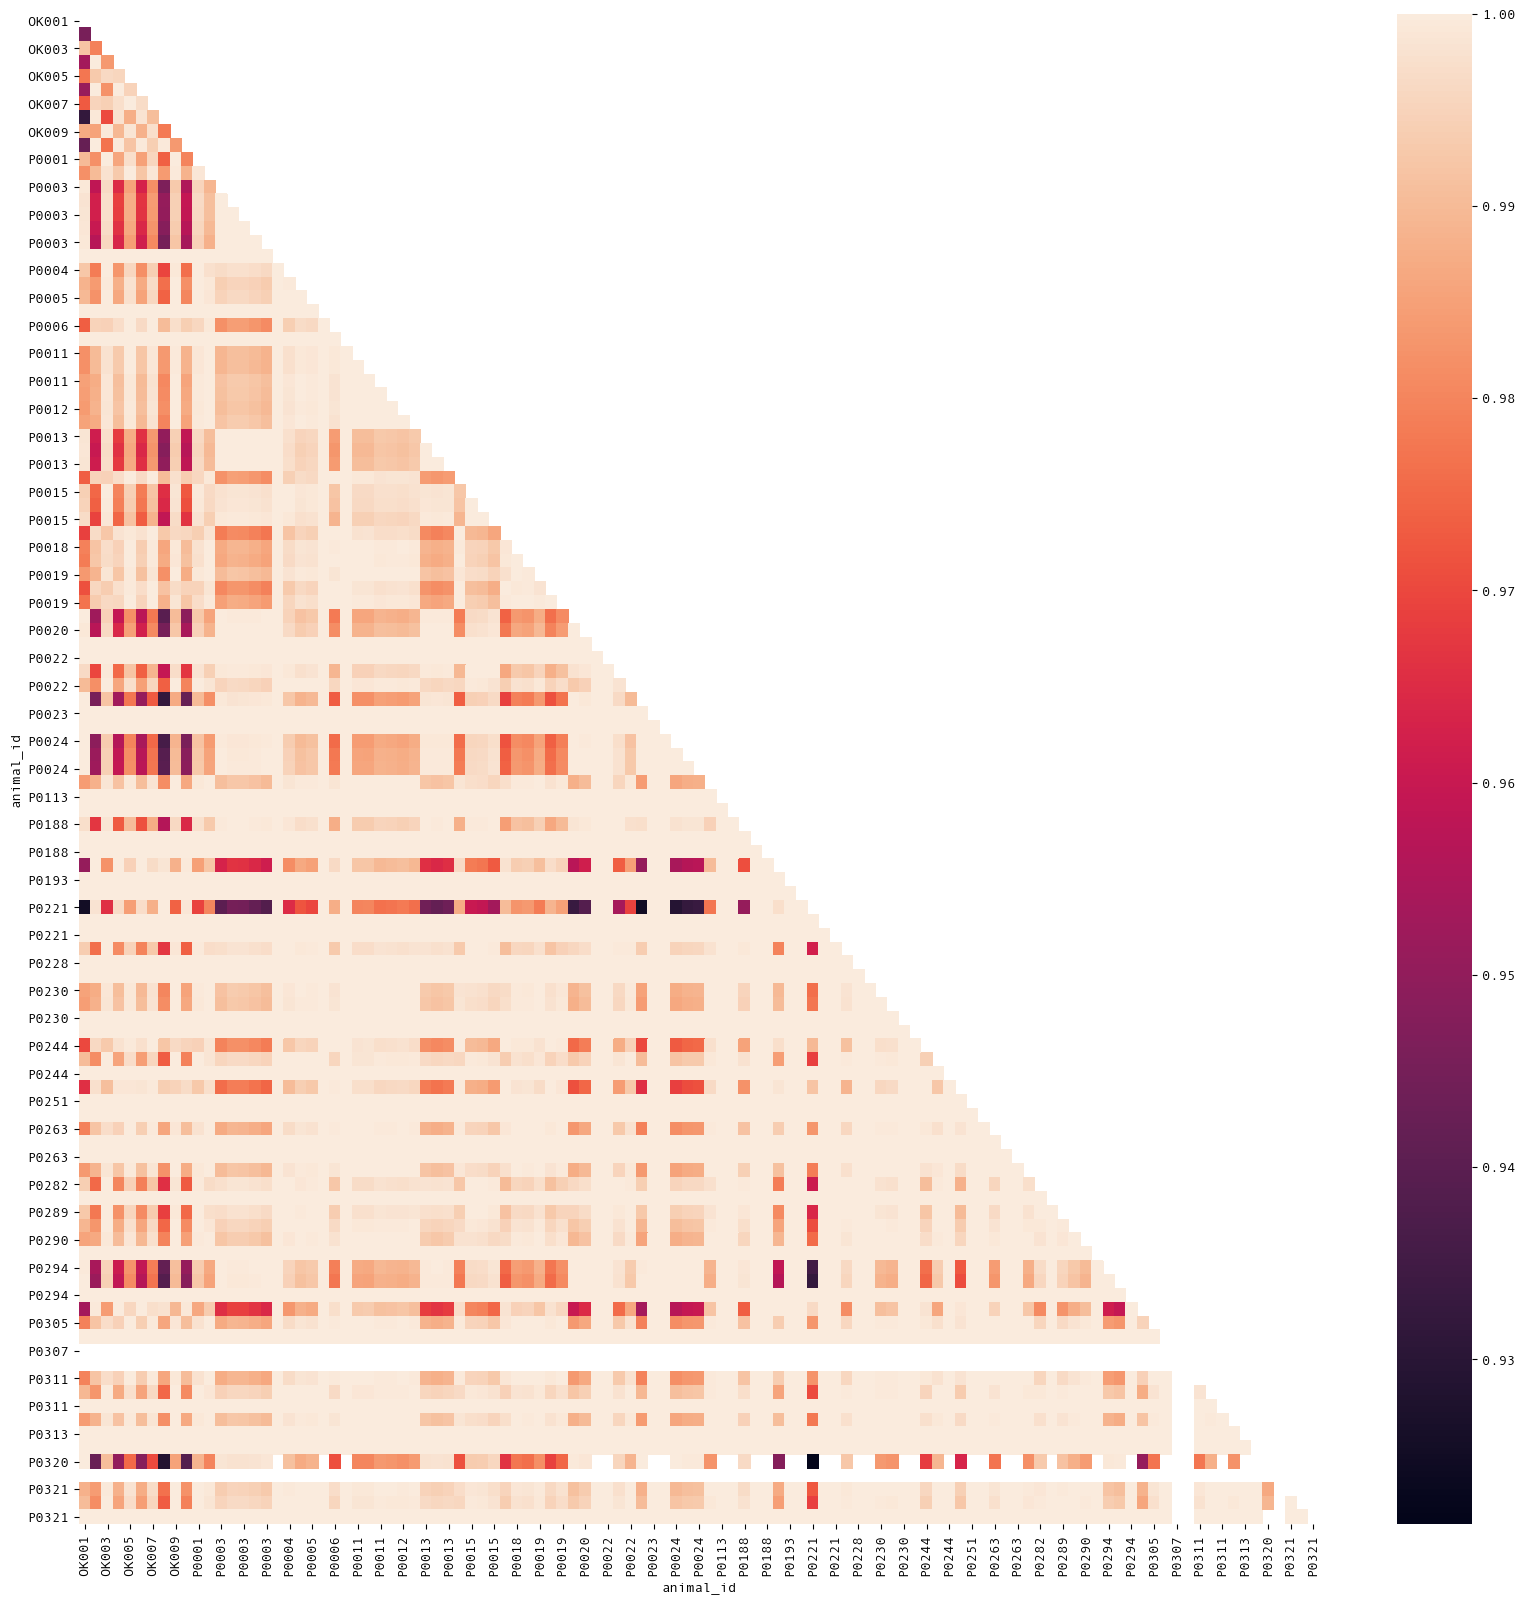

In [865]:
corr = transposed_animals.corr()
ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, mask=np.triu(np.ones_like(corr)))